In [4]:
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2
%pylab inline
import numpy as np
import tqdm
import shtns
import jax
import jax.numpy as jnp
import nfjax.shtlc as lc

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# SHT in Jax

The shtns library is very fast for single transforms but sometimes we want a high level implementation for e.g. autograd.  Here, we develop and test a drop-in replacement for the `shtns.sht` object.

Let's set up an SHT object for testing,

In [5]:
lmax, nlat, nlon = 31, 32, 64

sht = shtns.sht(lmax)
sht.set_grid(nlat=nlat, nphi=nlon)

[32, 64]

What methods do we use?

In [6]:
!grep 'sht\.' nfjax/shtlc.py

    sht.set_grid(nlat=nlat, nphi=nlon)
    "For shtns sht return random spatial array captured by sht."
    return sht.synth(sht.analys(np.random.randn(*sht.spat_array().shape)))
    K = sht.analys(k)
    im0 = np.array([sht.idx(int(_l), 0) for _l in sht.l])
    return 2*np.pi*np.sqrt(4*np.pi/(2*sht.l+1)) * K[im0]
    "Estimate effective kernel for kernel k with state x0 for shtns object sht."
    f = lambda x: sht.synth(k * sht.analys(x))
    gw = sht.gauss_wts()


most things are about the grid,

- `sht.__init__(lmax: int)` inits with trunction `lmax` set
- `sht.set_grid(nlat: int=nlat, nphi: int=nlon) -> tuple[int]` sets the grid
- `sht.l: ndarray[1, int32]` is sequence of `l` for elements of spectra
- `sht.m: ndarray[1, int32]` is sequence of `m` for elements of spectra
- `sht.guass_wts() -> ndarray[1, float64]` are weights for the latitudes on grid
- `sht.spat_array() -> np.ndarray` returns a correctly shaped array for the spatial grid

then just the forward & inverse transforms,

- `sht.analys(ndarray[2,float64]) -> ndarray[1,complex128]` transforms spatial to spectral data
- `sht.synth(ndarray[1,complex128]) -> ndarray[2,float64]` transforms spectral to spatial data

Let's start with the grid parts:

In [7]:
lm = lc.make_lm(lmax)
phi, _, gw = lc.make_grid(nlat, nlon)

# l & m determine which spherical harmonics are used
np.testing.assert_equal(lm[0], sht.l)
np.testing.assert_equal(lm[1], sht.m)

# phi are latitudes
np.testing.assert_equal(phi, np.arccos(sht.cos_theta))

# Gaussian weights for latitudes, symmetric so shtns stores only half
np.testing.assert_allclose(gw, 
                        np.r_[sht.gauss_wts(), sht.gauss_wts()[::-1]])

The spatial array is just zeros

In [8]:
np.testing.assert_equal(sht.spat_array(), np.zeros((nlat, nlon)))

That leaves the interesting part, the forward & inverse transforms.  Shtns uses recent recurrence formula to compute the $Y_{l,m}$ coefficients in the loop over latitudes, but for smaller problem sizes it's simpler to use precomputed matrices:

In [32]:
from scipy.special import sph_harm

# forward & inverse Legendre transform matrices
LT = []
iLT = []
L = []
D = 0.00047108

# each longitudinal frequency mode `m` needs its own forward & inverse matrices
for m in range(lmax):
    l = lm[0, lm[0]>=m]
    LT.append( gw[None, :] * sph_harm(m, l[:, None], 0, phi[None, :]).conjugate() )
    iLT.append(              sph_harm(m, l[None, :], 0, phi[:, None])             )
    dll = D * l * (l + 1)
    L.append(iLT[-1].dot(dll[:, None] * LT[-1]))
    
L = np.array(L)
np.testing.assert_allclose(0,L.imag)
L = L.real
# LT, iLT = np.array(LT), np.array(iLT) doesn't work because they have varying shapes

We can see what the action of that is here:

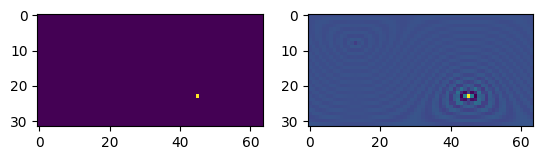

In [47]:
def apply(L, x):
    X = np.fft.rfft(x, axis=1)
    X[:,:lmax] = np.einsum('abc,ca->ba',L,X[:,:lmax])
    X[:,lmax:] = 0.0
    y = np.fft.irfft(X, axis=1).real
    return y

x0 = np.zeros((nlat, nlon))
x0[23,45] = 1.0
x1 = apply(L, x0)
subplot(121); imshow(x0)
subplot(122); imshow(x1)

Looks good, let's see the timing:

In [48]:
%timeit apply(L, x0)

62.1 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


If we wanted to keep the kernel flexible, then the operations are a bit different

3.17 ms ± 265 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


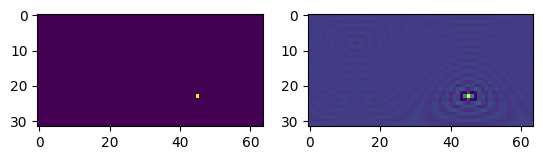

In [126]:
import numba
from numba.typed import List

@numba.njit
def apply_LT(lmax, LT, iLT, dll, X):
    for j in range(lmax):
        Lj = iLT[j].dot(dll[:LT[j].shape[0]] * LT[j]) #.real
        X[j] = Lj @ X[j]

def apply_kernel(lmax, LT, iLT, dll, x):
    X = np.fft.rfft(x, axis=1).T.copy()
    apply_LT(lmax, LT, iLT, dll, X)
    X[lmax:] = 0.0
    y = np.fft.irfft(X.T, axis=1).real
    return y

# try numba typed lists
LT_tl, iLT_tl = List(LT), List(iLT)
dll = (D*sht.l*(sht.l + 1))[:,None]
%timeit apply_kernel(lmax, LT_tl, iLT_tl, dll, x0)

x0 = np.zeros((nlat, nlon))
x0[23,45] = 1.0
x1 = apply_kernel(lmax, LT_tl, iLT_tl, dll, x0)
subplot(121); imshow(x0)
subplot(122); imshow(x1)

Unfortunately that's about 60x slower, with loop in there.  Is this something we can address with Jax JIT? Let's isolate that loop,

In [136]:
def apply_LT(lmax, LT, iLT, dll, X):
    for j in range(lmax):
        Lj = iLT[j].dot(dll[:LT[j].shape[0]] * LT[j]).real
        X[j] = Lj @ X[j]

x = np.zeros((nlat, nlon), 'f')
X = np.fft.rfft(x, axis=1).T.copy()
fLT = [_.astype(np.complex64) for _ in LT]
fiLT = [_.astype(np.complex64) for _ in iLT]
fdll = dll.astype('f')
%timeit apply_LT(lmax, fLT, fiLT, fdll, X)

2.55 ms ± 230 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [130]:
import jax
import jax.numpy as jnp

In [142]:
def j_apply_LT(lmax, LT, iLT, dll, X):
    for j in range(lmax):
        Lj = iLT[j].dot(dll[:LT[j].shape[0]] * LT[j]).real
        X.at[j].set(Lj @ X[j])

x = jnp.zeros((nlat, nlon))
X = jnp.fft.rfft(x, axis=1).T.copy()
jLT = [jnp.array(_) for _ in fLT]
jiLT = [jnp.array(_) for _ in fiLT]
jdll = jnp.array(fdll)
%timeit j_apply_LT(lmax, jLT, jiLT, jdll, X)

20.1 ms ± 66.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Not so amazing but perhaps we need a functional approach

ok I don't grok vmap on pytrees.

In [157]:
xs = [jnp.r_[:n] for n in range(3,6)]
ys = [jnp.r_[:n] for n in range(3,6)]

f = lambda x, y: jnp.dot(x,y)

list(map(f, xs, ys))

[Array(5, dtype=int32), Array(14, dtype=int32), Array(30, dtype=int32)]

In [184]:
f = lambda jLT, jiLT: jnp.array(jax.tree_map(jnp.dot, jiLT, jLT))
f(jLT,jiLT)
%timeit f(jLT,jiLT)
jitf = jax.jit(f)
jitf(jLT,jiLT)
%timeit jitf(jLT,jiLT)

4.23 ms ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.92 ms ± 7.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This step doesn't have to be super fast, precomputed L once per simulation is fine since the kernel won't evolve in time.

In [191]:
jiLT[0].shape, jdll.shape, jLT[0].shape

((32, 528), (528, 1), (528, 32))

In [204]:
jax.tree_map?

In [252]:
def compute_L(jLT, jiLT, jdll):
    return jnp.array(jax.tree_map(
        lambda lj, ilj: jnp.dot(ilj, jdll[:lj.shape[0]]*lj).real,
        jLT, jiLT,
    ))

def close_L_for_D(jLT, jiLT, l):
    @jax.jit
    def L_for_D(D):
        jdll = D * l * (l + 1)
        return compute_L(jLT, jiLT, jdll)
    return L_for_D

@jax.jit
def apply_L(L, x):
    X = jnp.fft.rfft(x, axis=1)
    # X[:,:lmax] = jnp.einsum('abc,ca->ba',L,X[:,:lmax])
    # X[:,lmax:] = 0.0
    X = jnp.hstack(
        (jnp.einsum('abc,ca->ba', L, X[:,:lmax]),
         jnp.zeros((X.shape[0], X.shape[1] - lmax), jnp.complex64)
        )
    )
    y = jnp.fft.irfft(X, axis=1).real
    return y

jl = jnp.array(sht.l)[:,None]
l4d = close_L_for_D(jLT, jiLT, jl)
L = l4d(D)
apply_L_np, L_np = lc.make_shtdiff(lmax, nlat, nlon, D, return_L=True)
np.testing.assert_equal(0, L_np.imag)
np.testing.assert_equal(0, np.array(L.imag))

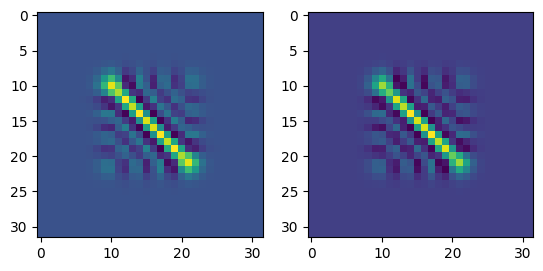

In [253]:
j = 25
subplot(121); imshow(L_np[j].real)
subplot(122); imshow(L[j].real)

37.1 µs ± 61.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
44.8 µs ± 37.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


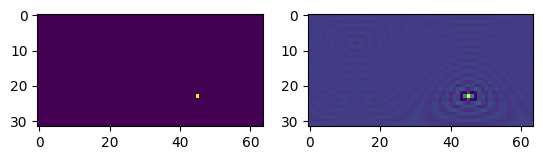

In [272]:
x0 = jnp.zeros((nlat, nlon))
x0 = x0.at[23,45].set(1.0)
x1 = apply_L(L, x0)
%timeit x1 = apply_L(L_np, x0).block_until_ready()
# x1 = apply_L_np(x0)
%timeit apply_L_np(x0)
subplot(121); imshow(x0)
subplot(122); imshow(x1)

There isn't too much issue with the pure numpy here, which is good to have in mind, in case we bail on Jax in the end:

- 250 ms to compute LT & iLT transform matrices
- 2 ms to compute L fused coupling matrices
- 30-50 us to apply fused coupling matrices

In [274]:
apply_many = jax.jit(jax.vmap(lambda x: apply_L(L, x)))

for n in (2, 32, 512):
    xs = jnp.zeros((n, nlat, nlon))
    apply_many(xs).shape
    %timeit apply_many(xs).block_until_ready()

45 µs ± 57.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
382 µs ± 222 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.97 ms ± 70.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
